# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=50,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_15-24-28/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5043 | MulticlassF1Score=0.1953
Batch-30 : CrossEntropyLoss=2.4663 | MulticlassF1Score=0.2273
Batch-45 : CrossEntropyLoss=2.4721 | MulticlassF1Score=0.2536
Batch-60 : CrossEntropyLoss=2.4346 | MulticlassF1Score=0.2809
Batch-75 : CrossEntropyLoss=2.4150 | MulticlassF1Score=0.3079
Batch-90 : CrossEntropyLoss=2.3990 | MulticlassF1Score=0.3299
Batch-105: CrossEntropyLoss=2.3747 | MulticlassF1Score=0.3570
Batch-120: CrossEntropyLoss=2.3623 | MulticlassF1Score=0.3847
Batch-135: CrossEntropyLoss=2.3602 | MulticlassF1Score=0.4068
Batch-150: CrossEntropyLoss=2.3568 | MulticlassF1Score=0.4251
Batch-165: CrossEntropyLoss=2.3594 | MulticlassF1Score=0.4399
Batch-180: CrossEntropyLoss=2.3522 | MulticlassF1Score=0.4565
Batch-195: CrossEntropyLoss=2.3359 | MulticlassF1Score=0.4733
Batch-210: CrossEntropyLoss=2.3572 | MulticlassF1Score=0.4877
Batch-225: CrossEntropyLoss=2.3501 | MulticlassF1Score=0.5004
Batch-226: CrossEntropyLoss=2.3565 | MulticlassF1Score=0.5010

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3480 | MulticlassF1Score=0.6748
Batch-30 : CrossEntropyLoss=2.3510 | MulticlassF1Score=0.6710
Batch-45 : CrossEntropyLoss=2.3487 | MulticlassF1Score=0.6732
Batch-60 : CrossEntropyLoss=2.3538 | MulticlassF1Score=0.6735
Batch-63 : CrossEntropyLoss=2.3794 | MulticlassF1Score=0.6734

Training   : Mean CrossEntropyLoss = 2.4156 | Mean MulticlassF1Score = 0.3587
Validation : Mean CrossEntropyLoss = 2.3503 | Mean MulticlassF1Score = 0.6761

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3495 | MulticlassF1Score=0.6712
Batch-30 : CrossEntropyLoss=2.3435 | MulticlassF1Score=0.6707
Batch-45 : CrossEntropyLoss=2.3322 | MulticlassF1Score=0.6720
Batch-60 : CrossEntropyLoss=2.3255 | MulticlassF1Score=0.6823
Batch-75 : CrossEntropyLoss=2.3347 | MulticlassF1Score=0.6902
Batch-90 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.6977
Batch-105: CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7064
Batch-120: CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7134
Batch-135: CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7202
Batch-150: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7268
Batch-165: CrossEntropyLoss=2.3136 | MulticlassF1Score=0.7324
Batch-180: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7372
Batch-195: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7410
Batch-210: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7446
Batch-225: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7481
Batch-226: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.7482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.7957
Batch-30 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7940
Batch-45 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7922
Batch-60 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.7919
Batch-63 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7919

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3269 | Mean MulticlassF1Score = 0.7082
Validation : Mean CrossEntropyLoss = 2.3131 | Mean MulticlassF1Score = 0.7928

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7960
Batch-30 : CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7912
Batch-45 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7929
Batch-60 : CrossEntropyLoss=2.3255 | MulticlassF1Score=0.7904
Batch-75 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.7928
Batch-90 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7913
Batch-105: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7920
Batch-120: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7916
Batch-135: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7921
Batch-150: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7923
Batch-165: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7938
Batch-180: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.7954
Batch-195: CrossEntropyLoss=2.3196 | MulticlassF1Score=0.7964
Batch-210: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.7973
Batch-225: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.7979
Batch-226: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.7980

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8020
Batch-30 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8075
Batch-45 : CrossEntropyLoss=2.3178 | MulticlassF1Score=0.8060
Batch-60 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8050
Batch-63 : CrossEntropyLoss=2.3179 | MulticlassF1Score=0.8051

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3106 | Mean MulticlassF1Score = 0.7932
Validation : Mean CrossEntropyLoss = 2.3086 | Mean MulticlassF1Score = 0.8051

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3100 | MulticlassF1Score=0.8122
Batch-30 : CrossEntropyLoss=2.3099 | MulticlassF1Score=0.8099
Batch-45 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8109
Batch-60 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8088
Batch-75 : CrossEntropyLoss=2.3096 | MulticlassF1Score=0.8095
Batch-90 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8092
Batch-105: CrossEntropyLoss=2.3086 | MulticlassF1Score=0.8104
Batch-120: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8093
Batch-135: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8092
Batch-150: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8088
Batch-165: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8090
Batch-180: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8089
Batch-195: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8107
Batch-210: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8121
Batch-225: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8128
Batch-226: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8127

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8225
Batch-30 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8238
Batch-45 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8269
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8255
Batch-63 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3059 | Mean MulticlassF1Score = 0.8101
Validation : Mean CrossEntropyLoss = 2.3021 | Mean MulticlassF1Score = 0.8249

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8338
Batch-30 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8331
Batch-45 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8326
Batch-60 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.8327
Batch-75 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8319
Batch-90 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8310
Batch-105: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8309
Batch-120: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8303
Batch-135: CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8295
Batch-150: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8296
Batch-165: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8296
Batch-180: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8299
Batch-195: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8294
Batch-210: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8296
Batch-225: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8297
Batch-226: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8298

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8224
Batch-30 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8258
Batch-45 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8257
Batch-60 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8269
Batch-63 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8311
Validation : Mean CrossEntropyLoss = 2.3015 | Mean MulticlassF1Score = 0.8253

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8271
Batch-30 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8310
Batch-45 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8310
Batch-60 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8299
Batch-75 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8292
Batch-90 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8300
Batch-105: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8301
Batch-120: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8310
Batch-135: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8310
Batch-150: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8307
Batch-165: CrossEntropyLoss=2.3072 | MulticlassF1Score=0.8308
Batch-180: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8309
Batch-195: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8310
Batch-210: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8314
Batch-225: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8318
Batch-226: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8318

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8303
Batch-30 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8261
Batch-45 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8266
Batch-60 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8275
Batch-63 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8306
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8287

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8439
Batch-30 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8380
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8351
Batch-75 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.8332
Batch-90 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8315
Batch-105: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8319
Batch-120: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8317
Batch-135: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8327
Batch-150: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8345
Batch-165: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8357
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8373
Batch-195: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8384
Batch-210: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8392
Batch-225: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8399
Batch-226: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8399

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8430
Batch-30 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8439
Batch-45 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8415
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8430
Batch-63 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8434

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2973 | Mean MulticlassF1Score = 0.8359
Validation : Mean CrossEntropyLoss = 2.2965 | Mean MulticlassF1Score = 0.8423

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8513
Batch-30 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8527
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8527
Batch-60 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8517
Batch-75 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8514
Batch-90 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8514
Batch-105: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8513
Batch-120: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8526
Batch-135: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8540
Batch-150: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8551
Batch-165: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8552
Batch-180: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8556
Batch-195: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8557
Batch-210: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8556
Batch-225: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8554
Batch-226: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8554

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8517
Batch-30 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8516
Batch-45 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8530
Batch-60 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8536
Batch-63 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8532

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2926 | Mean MulticlassF1Score = 0.8532
Validation : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8523

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8567
Batch-30 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8610
Batch-45 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8606
Batch-60 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8616
Batch-75 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8616
Batch-90 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8627
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8629
Batch-120: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8622
Batch-135: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8618
Batch-150: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8619
Batch-165: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8625
Batch-180: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8643
Batch-195: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8656
Batch-210: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8670
Batch-225: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8682
Batch-226: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8826
Batch-30 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8809
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8813
Batch-60 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8808
Batch-63 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8811

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2886 | Mean MulticlassF1Score = 0.8626
Validation : Mean CrossEntropyLoss = 2.2850 | Mean MulticlassF1Score = 0.8813

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8901
Batch-30 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8883
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8883
Batch-60 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8898
Batch-75 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8902
Batch-90 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8904
Batch-105: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8899
Batch-120: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8900
Batch-135: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8900
Batch-150: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8902
Batch-165: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8903
Batch-180: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8905
Batch-195: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8905
Batch-210: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8921
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8934
Batch-226: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8934

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8979
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9048
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9063
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9057
Batch-63 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9058

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8904
Validation : Mean CrossEntropyLoss = 2.2774 | Mean MulticlassF1Score = 0.9030

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9188
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9172
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9178
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9183
Batch-75 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9176
Batch-90 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9178
Batch-105: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9174
Batch-120: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9178
Batch-135: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9178
Batch-150: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9176
Batch-165: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9180
Batch-180: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9184
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9190
Batch-210: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9192
Batch-225: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9191
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9192

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9128
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9125
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9132
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9133
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9182
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9135

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9248
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9245
Batch-90 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9247
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9254
Batch-120: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9255
Batch-135: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9253
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9253
Batch-165: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9250
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9256
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9257
Batch-210: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9255
Batch-225: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9253
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9253

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9157
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9161
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9158
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9144
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9150

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9252
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9168

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9272
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9274
Batch-90 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9282
Batch-105: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9277
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9275
Batch-135: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9274
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9276
Batch-165: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9276
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9275
Batch-195: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9276
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9271
Batch-225: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9271
Batch-226: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9270

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9140
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9138
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9153
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9151
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9154

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9272
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9138

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9302
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9285
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9284
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9295
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9299
Batch-105: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9300
Batch-120: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9292
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9293
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9289
Batch-165: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9291
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9291
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9290
Batch-210: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9287
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9287

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9100
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9140
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9146
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9156
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9155

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9292
Validation : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9141

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9313
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9303
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9307
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9321
Batch-75 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9307
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9309
Batch-105: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9308
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9305
Batch-135: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9303
Batch-150: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9301
Batch-165: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9300
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9295
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9296
Batch-210: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9296
Batch-225: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9297
Batch-226: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9297

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9171
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9160
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9163
Batch-63 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9160

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2695 | Mean MulticlassF1Score = 0.9305
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9175

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9290
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9292
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9298
Batch-105: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9298
Batch-120: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9307
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9308
Batch-150: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9306
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9308
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9307
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9310
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9310
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9309
Batch-226: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9308

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9180
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9176
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9169
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9157
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9161

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2691 | Mean MulticlassF1Score = 0.9301
Validation : Mean CrossEntropyLoss = 2.2738 | Mean MulticlassF1Score = 0.9167

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9323
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9329
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9325
Batch-75 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9309
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9310
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9307
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9301
Batch-135: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9307
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9308
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9308
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9310
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9312
Batch-210: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9312
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9313
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9314

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.9155
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9182
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9191
Batch-60 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9177
Batch-63 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9176

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9313
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9176

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9330
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9348
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9328
Batch-75 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9318
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9327
Batch-105: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9326
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9327
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9328
Batch-150: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9331
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9325
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9325
Batch-195: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9323
Batch-210: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9323
Batch-225: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9322
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9322

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9144
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9171
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9178
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9173
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9173

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9325
Validation : Mean CrossEntropyLoss = 2.2733 | Mean MulticlassF1Score = 0.9148

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9333
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9336
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9335
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9335
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9336
Batch-105: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9328
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9329
Batch-135: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9337
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9333
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9334
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9338
Batch-195: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9336
Batch-210: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9334
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9333
Batch-226: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9332

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.9182
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9174
Batch-63 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9171

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9333
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9198

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9362
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9352
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9351
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9346
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9348
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9350
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9349
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9352
Batch-135: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9348
Batch-150: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9345
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9346
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9344
Batch-195: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9342
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9340
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9340

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9156
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9158
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9172
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9173
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9175

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9349
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9167

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9349
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9372
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9357
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9360
Batch-75 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9354
Batch-90 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9355
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9354
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9350
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9353
Batch-150: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9349
Batch-165: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9346
Batch-180: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9344
Batch-195: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9345
Batch-210: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9345
Batch-225: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9345
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9345

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9147
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9134
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9151
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9170
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9171

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9353
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9152

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9376
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9369
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9367
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9370
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9364
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9361
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9359
Batch-135: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9358
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9354
Batch-165: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9350
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9350
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9352
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9354
Batch-225: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9352
Batch-226: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9352

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9195
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9184
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9164
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9167
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9167

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9362
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9176

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9348
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9334
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9349
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9356
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9351
Batch-90 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9355
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9357
Batch-120: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9360
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9359
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9362
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9358
Batch-180: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9357
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9356
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9356

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9138
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9175
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9184
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9178
Batch-63 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9177

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9353
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9162

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9377
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9386
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9379
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9374
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9374
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9375
Batch-165: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9370
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9367
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9363
Batch-210: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9361
Batch-225: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9360
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9361

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9193
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9167
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9173
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9172
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9175

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9371
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9173

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9344
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9325
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9335
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9345
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9351
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9348
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9354
Batch-120: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9352
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9357
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9362
Batch-165: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9358
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9362
Batch-195: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9364
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9366
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9363
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9364

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9139
Batch-30 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9154
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9174
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9177
Batch-63 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9175

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9353
Validation : Mean CrossEntropyLoss = 2.2732 | Mean MulticlassF1Score = 0.9153

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9386
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9383
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9382
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9377
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9377
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9374
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9376
Batch-180: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9374
Batch-195: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9371
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9371
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9369
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9369

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9191
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9189
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9186

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9383
Validation : Mean CrossEntropyLoss = 2.2728 | Mean MulticlassF1Score = 0.9208

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9390
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9381
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9386
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9375
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9371
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9373
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9373
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9374
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9374
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9374
Batch-225: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9375
Batch-226: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9198
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2668 | Mean MulticlassF1Score = 0.9382
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9222

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9394
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9405
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9409
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9407
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9411
Batch-180: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9239
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9238

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9405
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9250

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9407
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9418
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9410
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9415
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9416
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9422
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9424
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9424
Batch-225: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9422
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9422

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9253

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9430
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9439
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9438
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9436
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9433
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9433
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9261
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9251

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9445
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9444
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9446
Batch-135: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9442
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9439

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9254
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9238
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9246
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9449
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9262

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9444
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9439
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9440
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9442
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9443
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9444
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9253
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9237
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9237
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9242

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9445
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9246

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9439
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9446
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9447
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9450
Batch-226: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9450

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9274
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9439
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9262

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9488
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9474
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9473
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9456
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9453
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9452
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9455
Batch-225: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9252

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9236

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9454
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9455
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9454
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9457
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9459

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9249
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9248

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9468
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9465
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9463
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9464
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9254
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9257

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9250

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9450
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9458
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9457
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9458
Batch-195: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9461
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9259

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9484
Batch-75 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9460
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9463
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9250

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9468
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9248

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9472
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9474
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9466
Batch-150: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9463
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9255

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9267
Patience = 1/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9463
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9472
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9469
Batch-135: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9468
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9463
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9248

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9468
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9238
Patience = 2/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9462
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9470
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9468
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9468
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9468
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9468
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9256

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9459
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9463
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9462
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9466
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9469
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9232

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9474
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9469
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9464
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9472
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9475
Batch-195: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9474
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9248
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9260

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9437
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9471
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9471
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9464
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9250

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9474
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9474
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9475
Batch-180: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9474
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9474
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9475
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9475

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9254
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9473
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9250

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9512
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9531
Batch-90 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9555
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9570
Batch-120: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9578
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9588
Batch-150: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9591
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9597
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9603
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9607
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9614
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9615
Batch-226: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9616

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9443
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9447
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9449

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9556
Validation : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9460

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9651
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9662
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9668
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9671
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9673
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9674

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9411
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9453

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9435

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9693
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9678

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9445
Batch-45 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9454

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9448

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9724
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9452
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9456

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9440

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2517 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2516 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9482

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2569
Best CrossEntropyLoss training    : 2.2635
Best MulticlassF1Score validation : 0.9691
Best MulticlassF1Score validation : 0.9482
Training duration                 : 2.7089 minutes.
Training date                     : 2022-10-19 10:52:53.569297+08:00


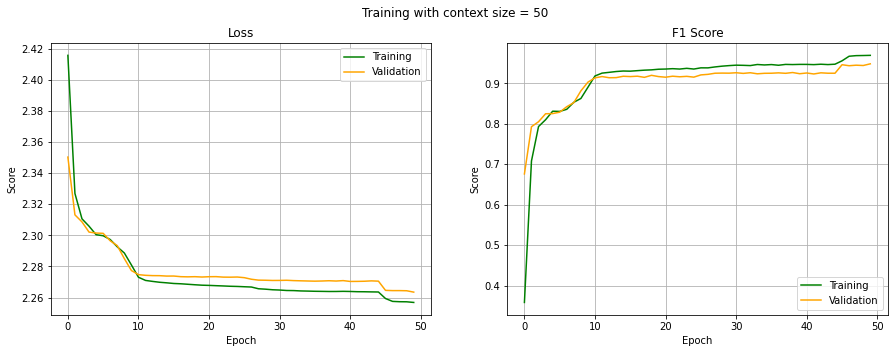

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9710, device='cuda:0'),
 tensor(0.9487, device='cuda:0'),
 tensor(0.9502, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9710, device='cuda:0'),
 tensor(0.9487, device='cuda:0'),
 tensor(0.9502, device='cuda:0'))

## Heatmap

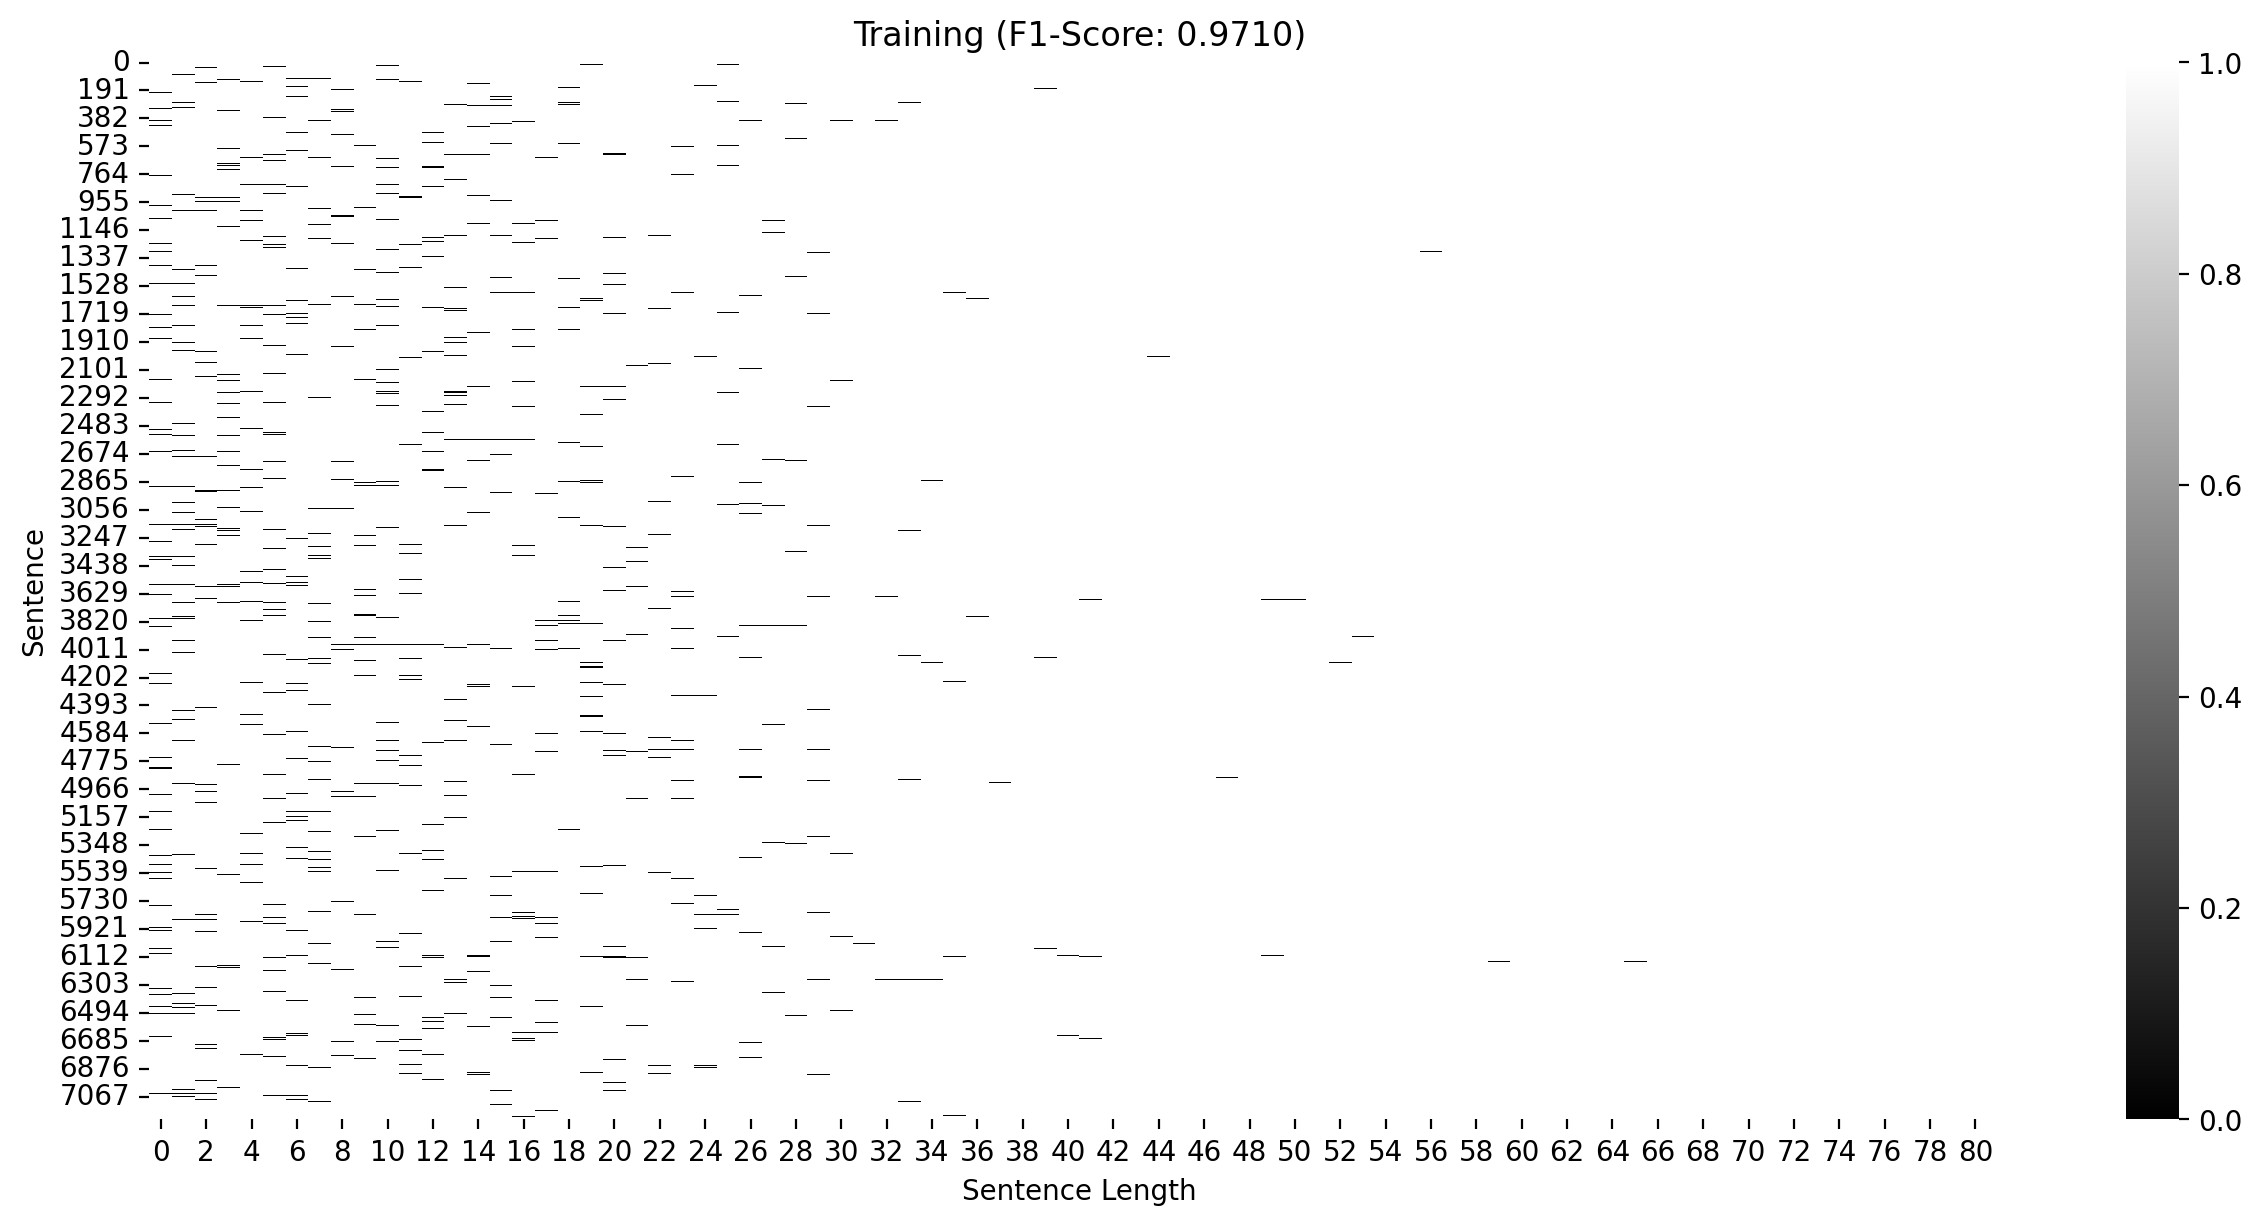

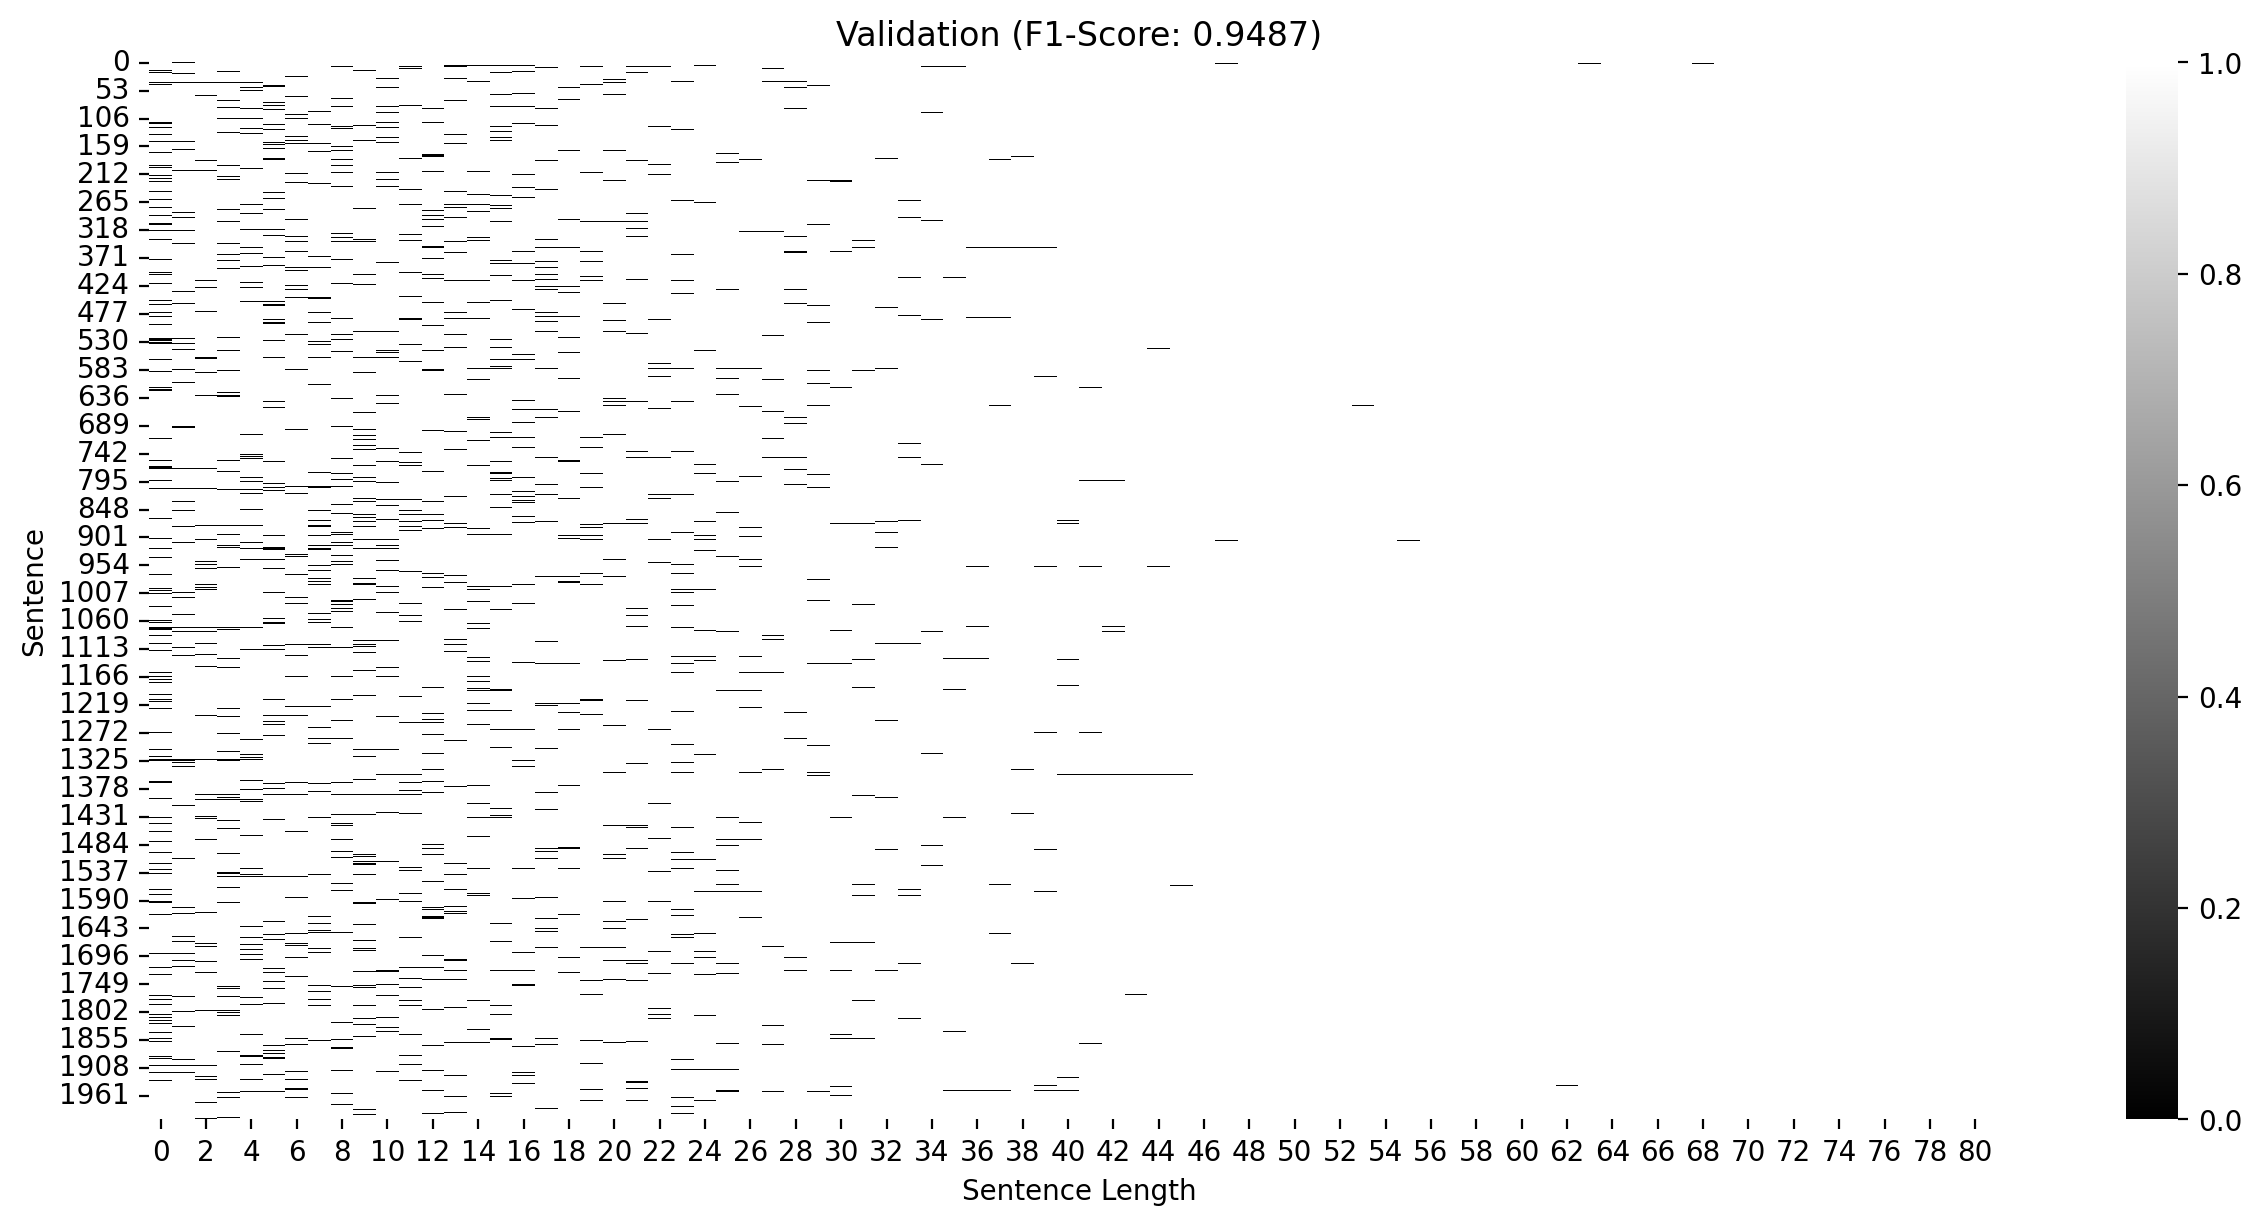

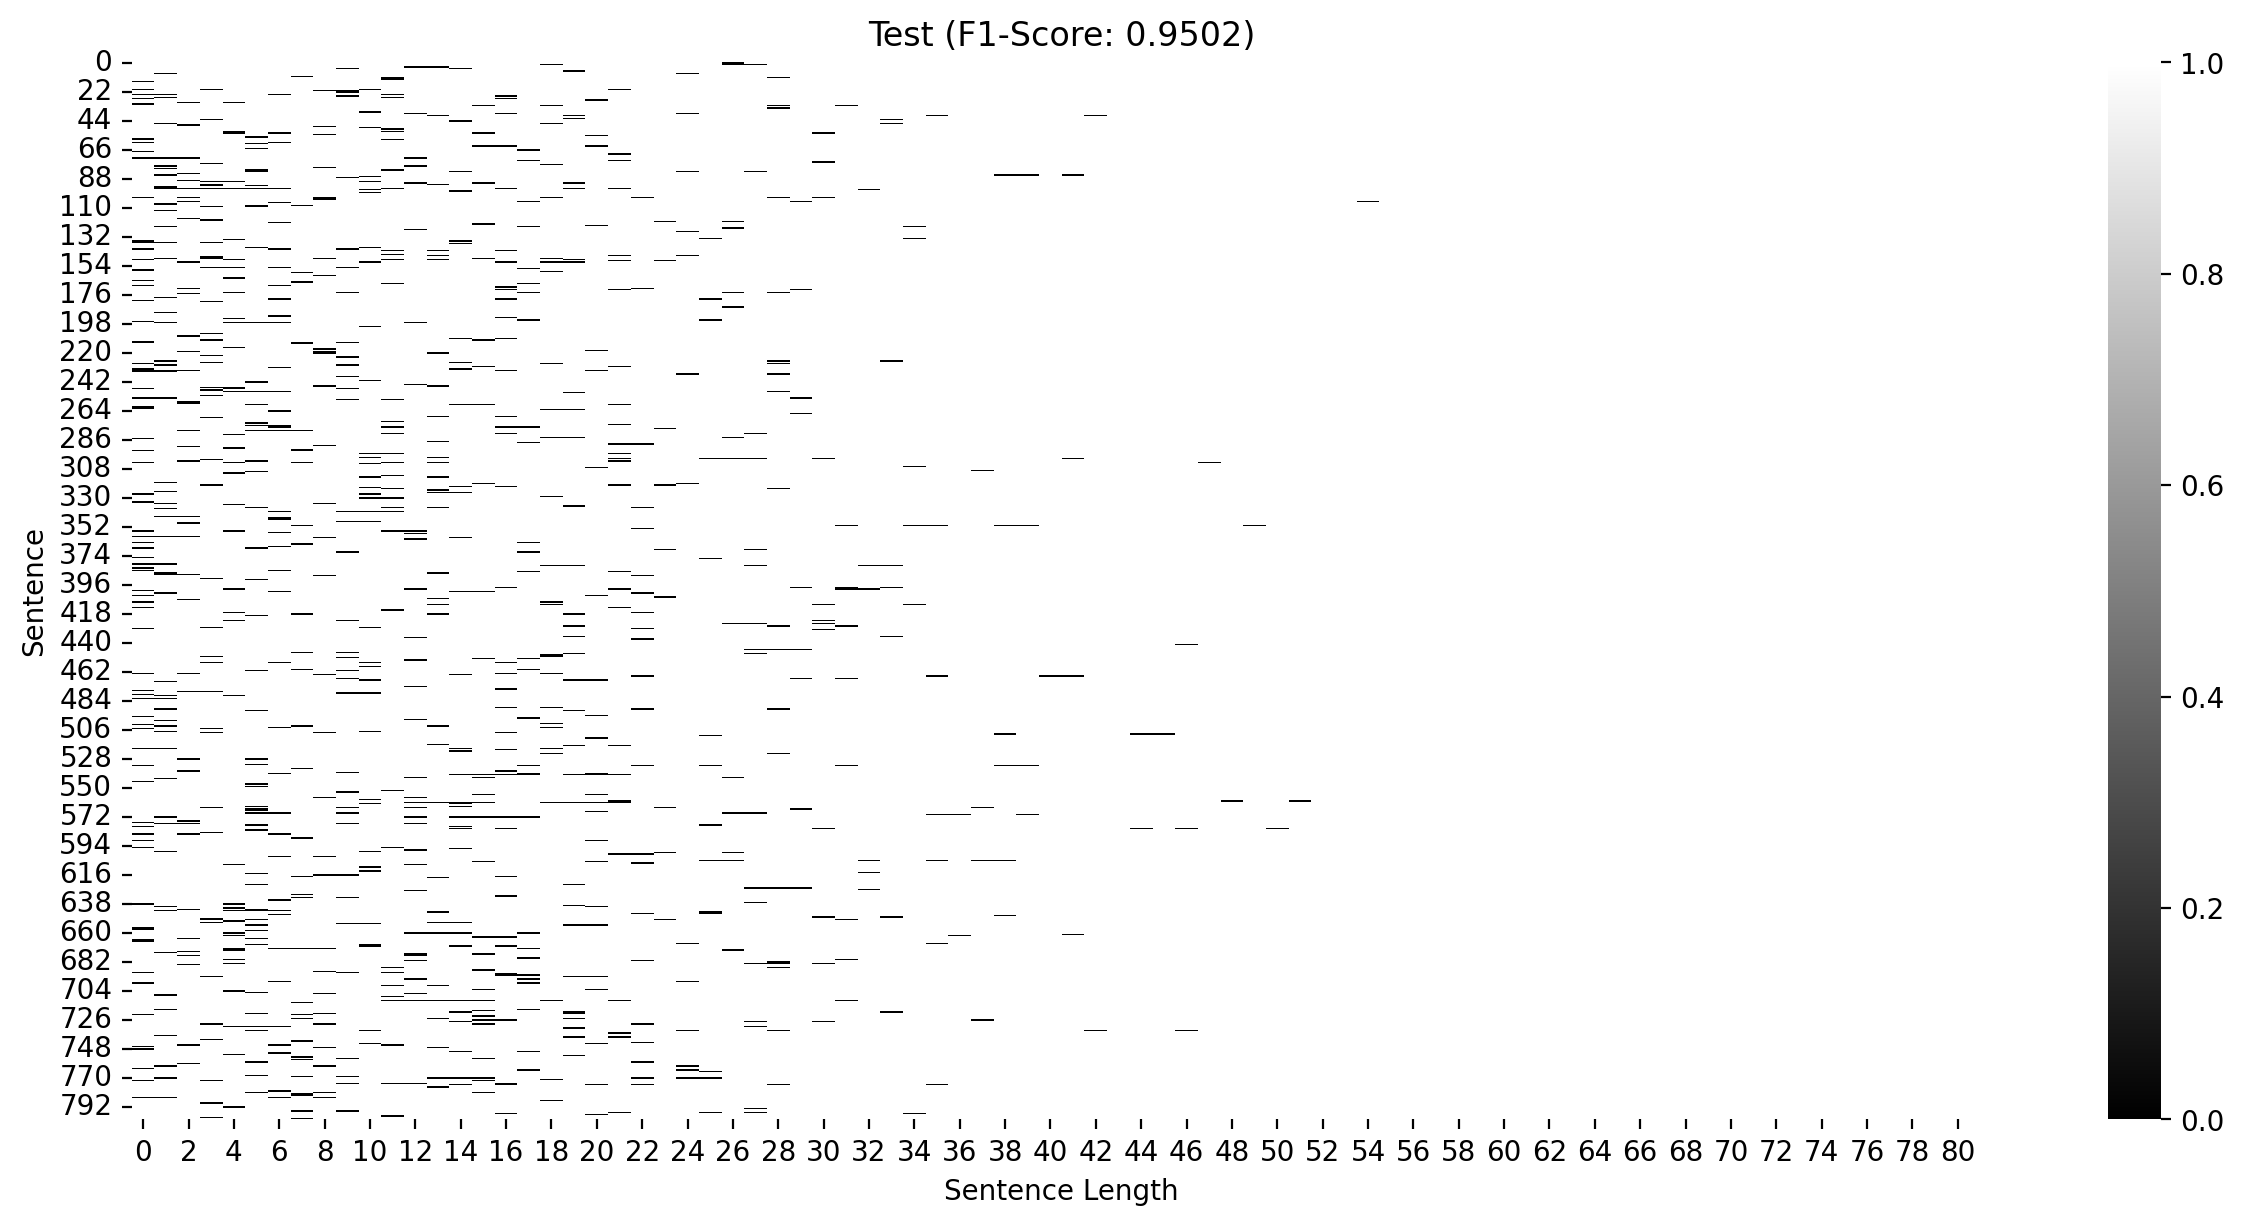

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


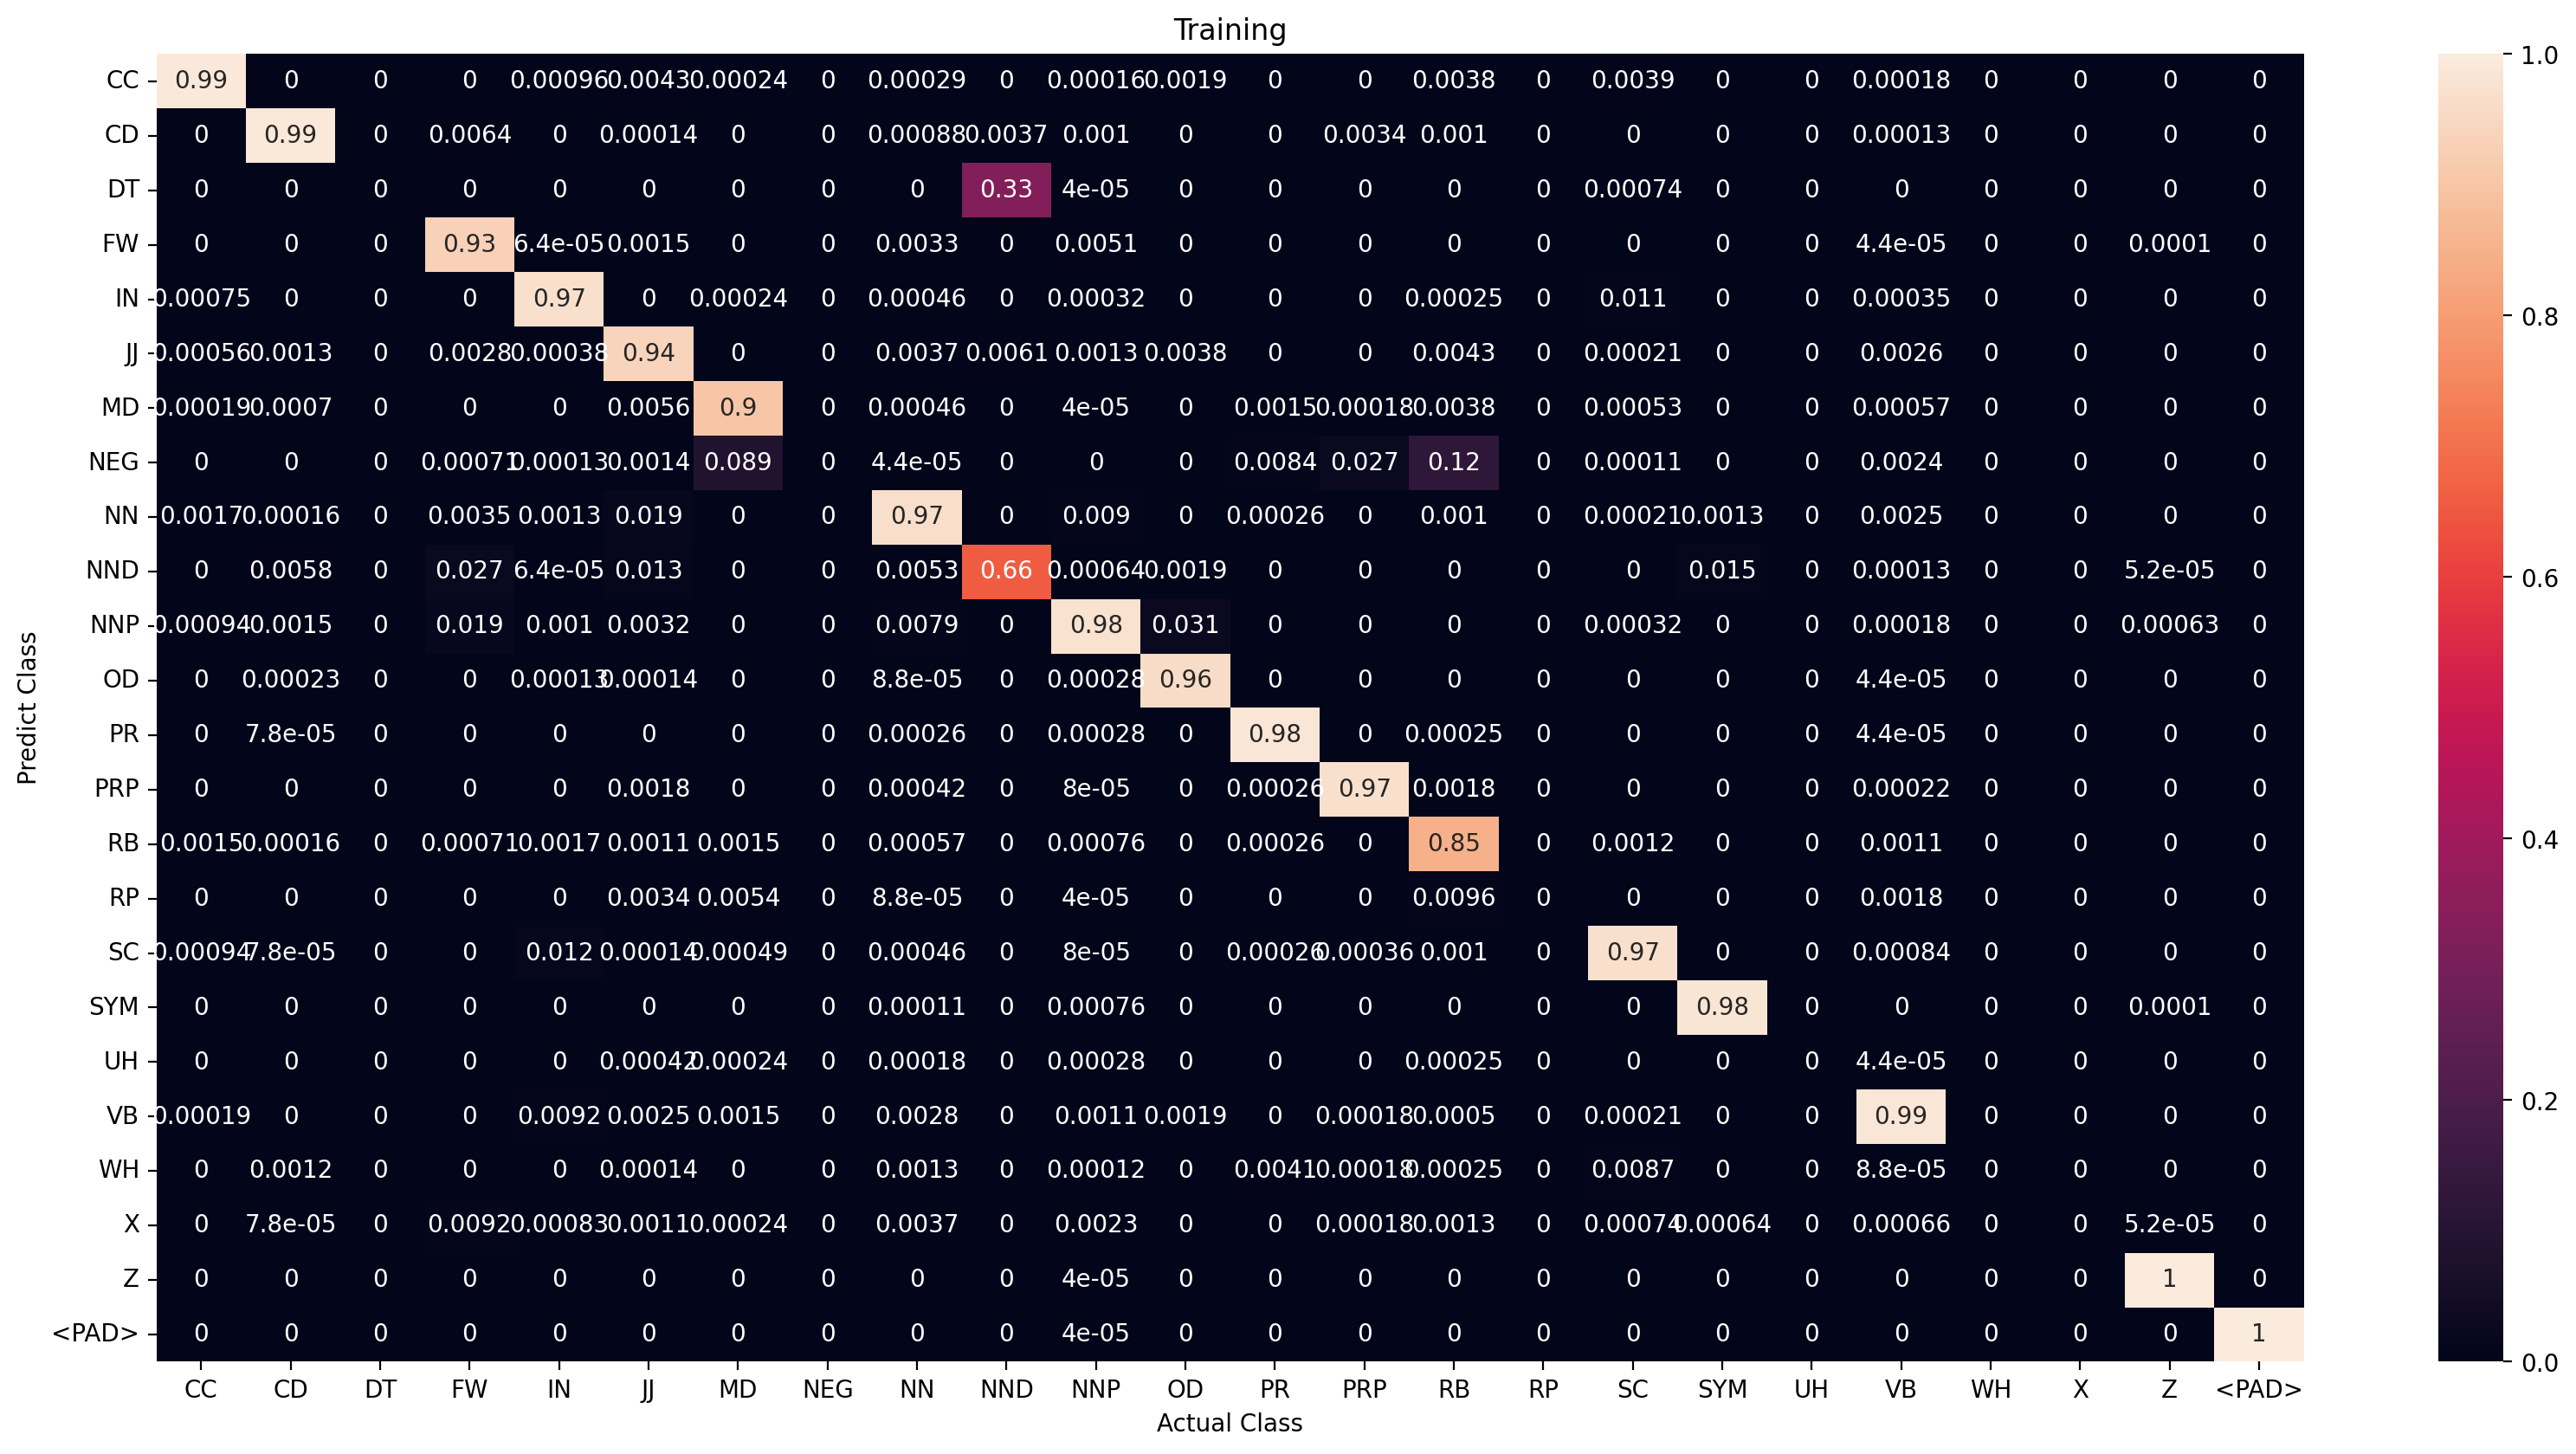

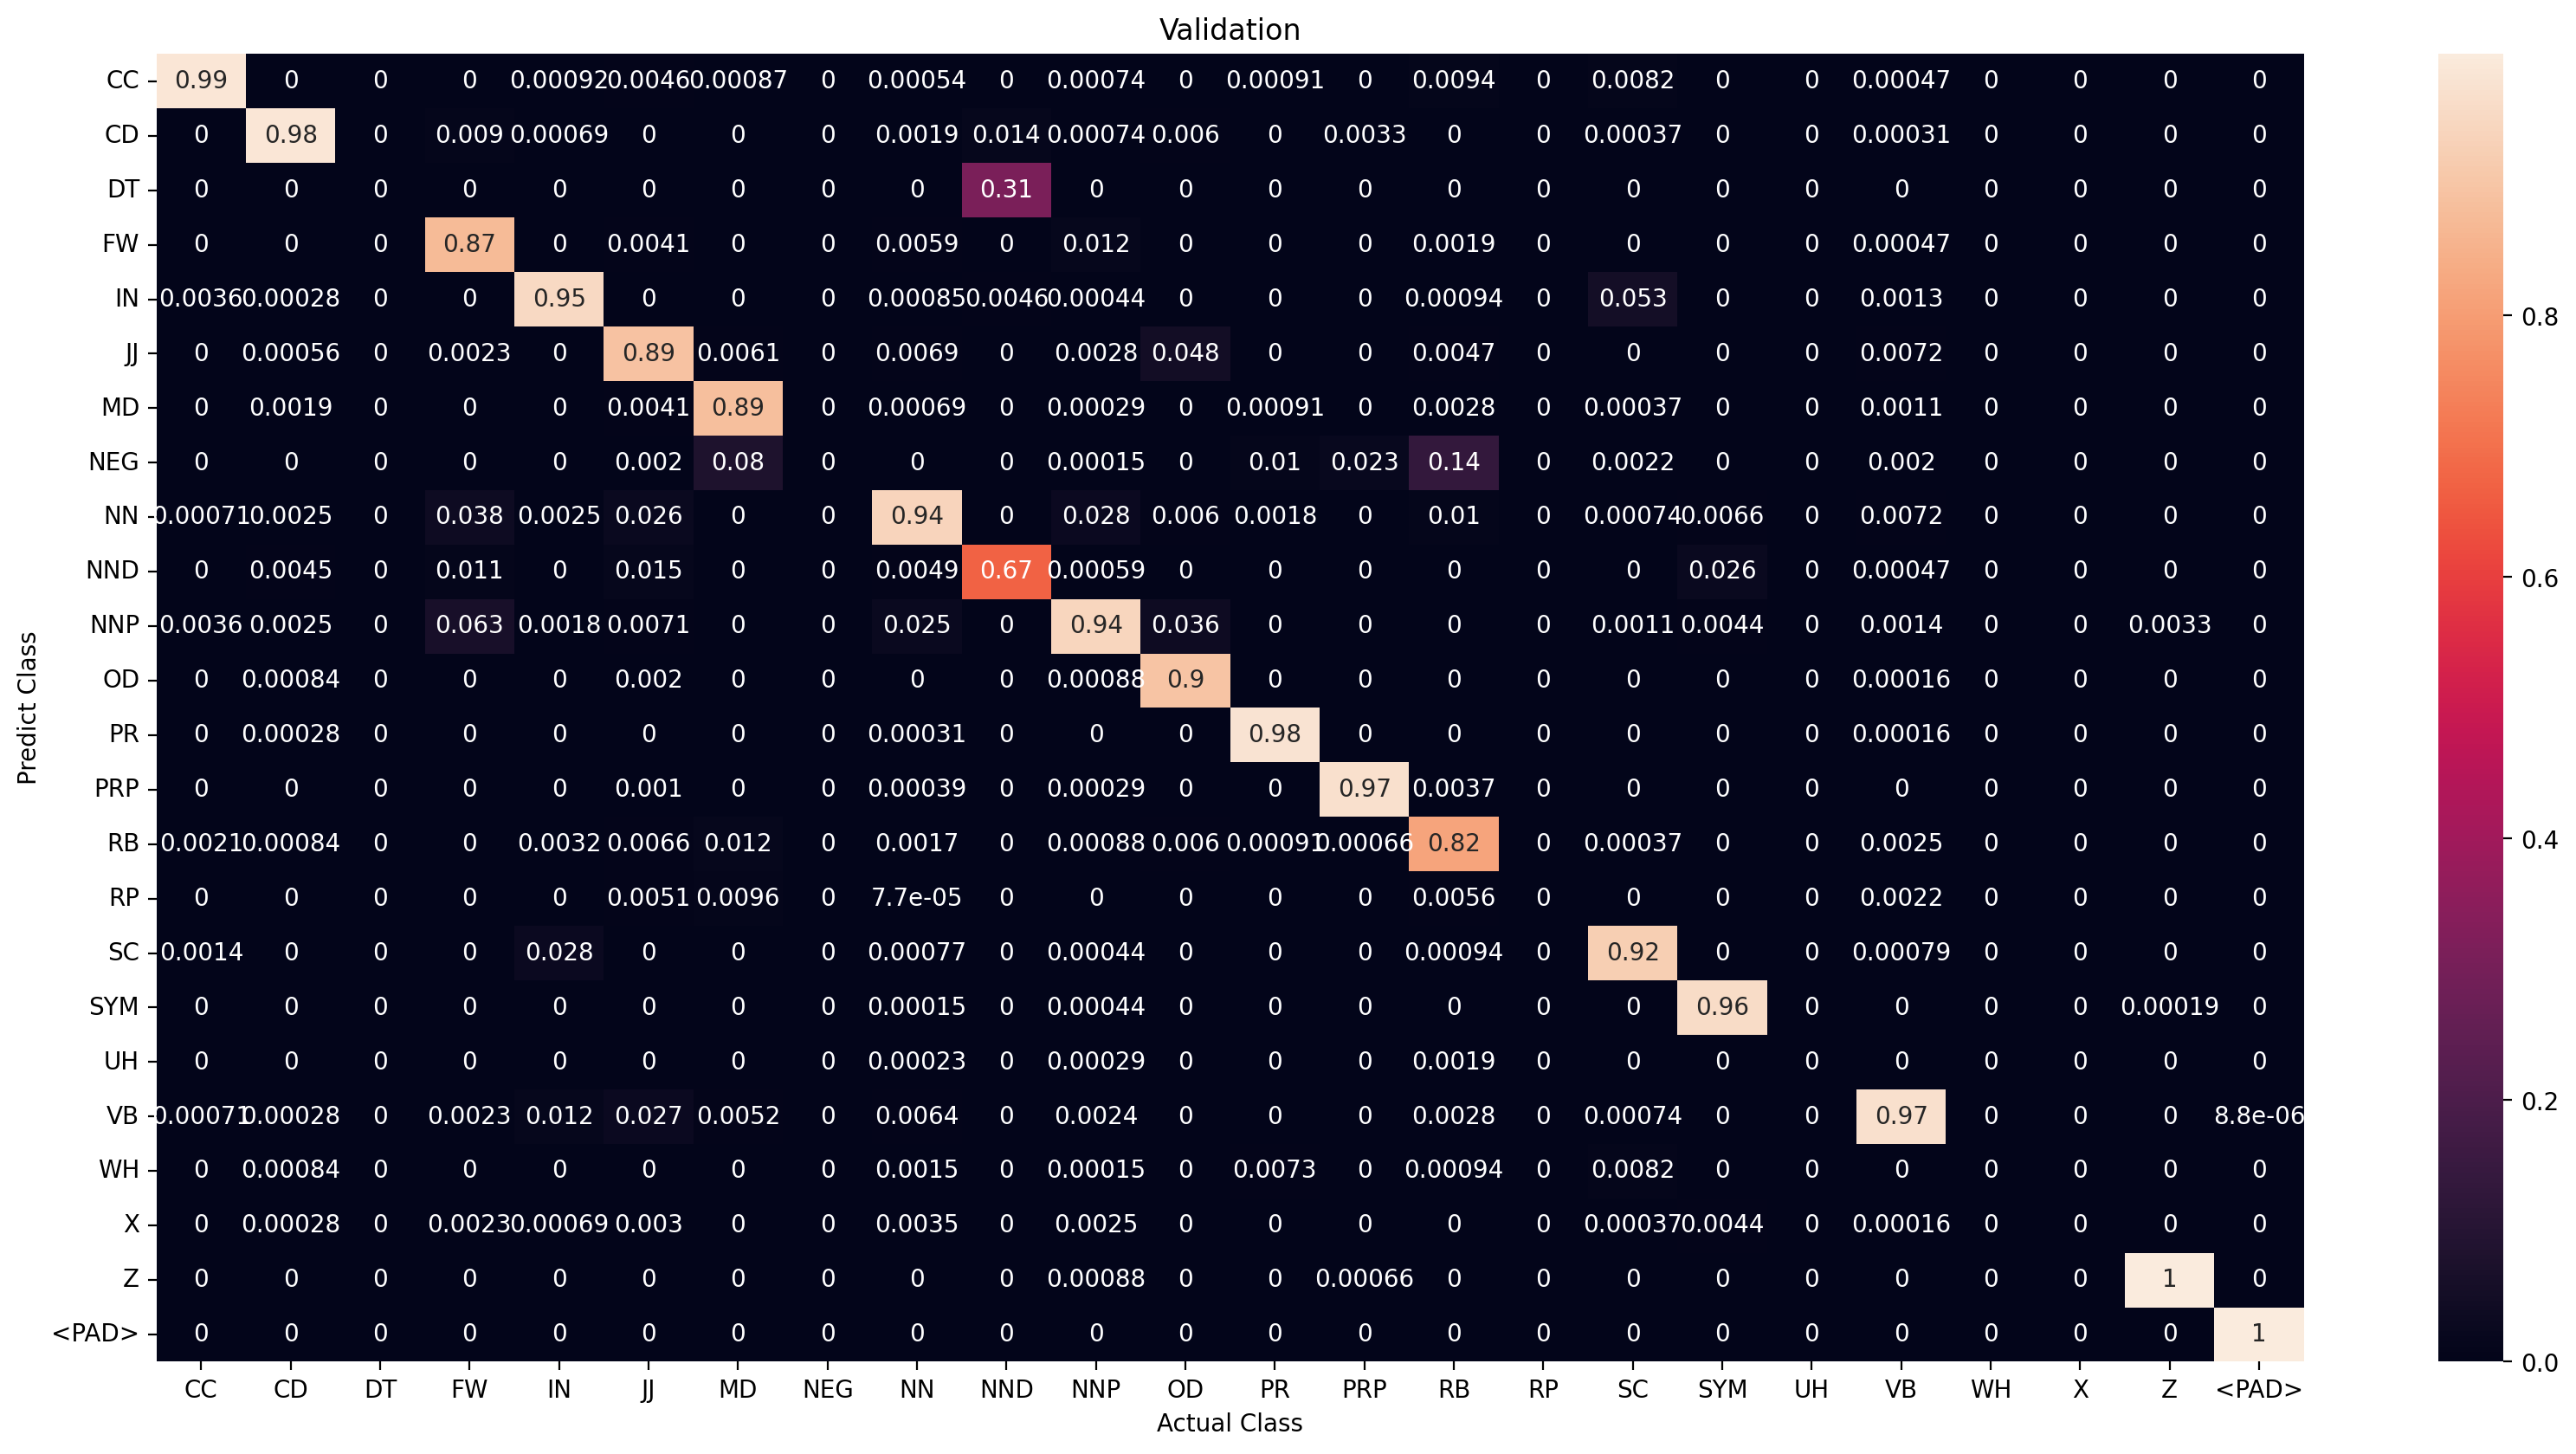

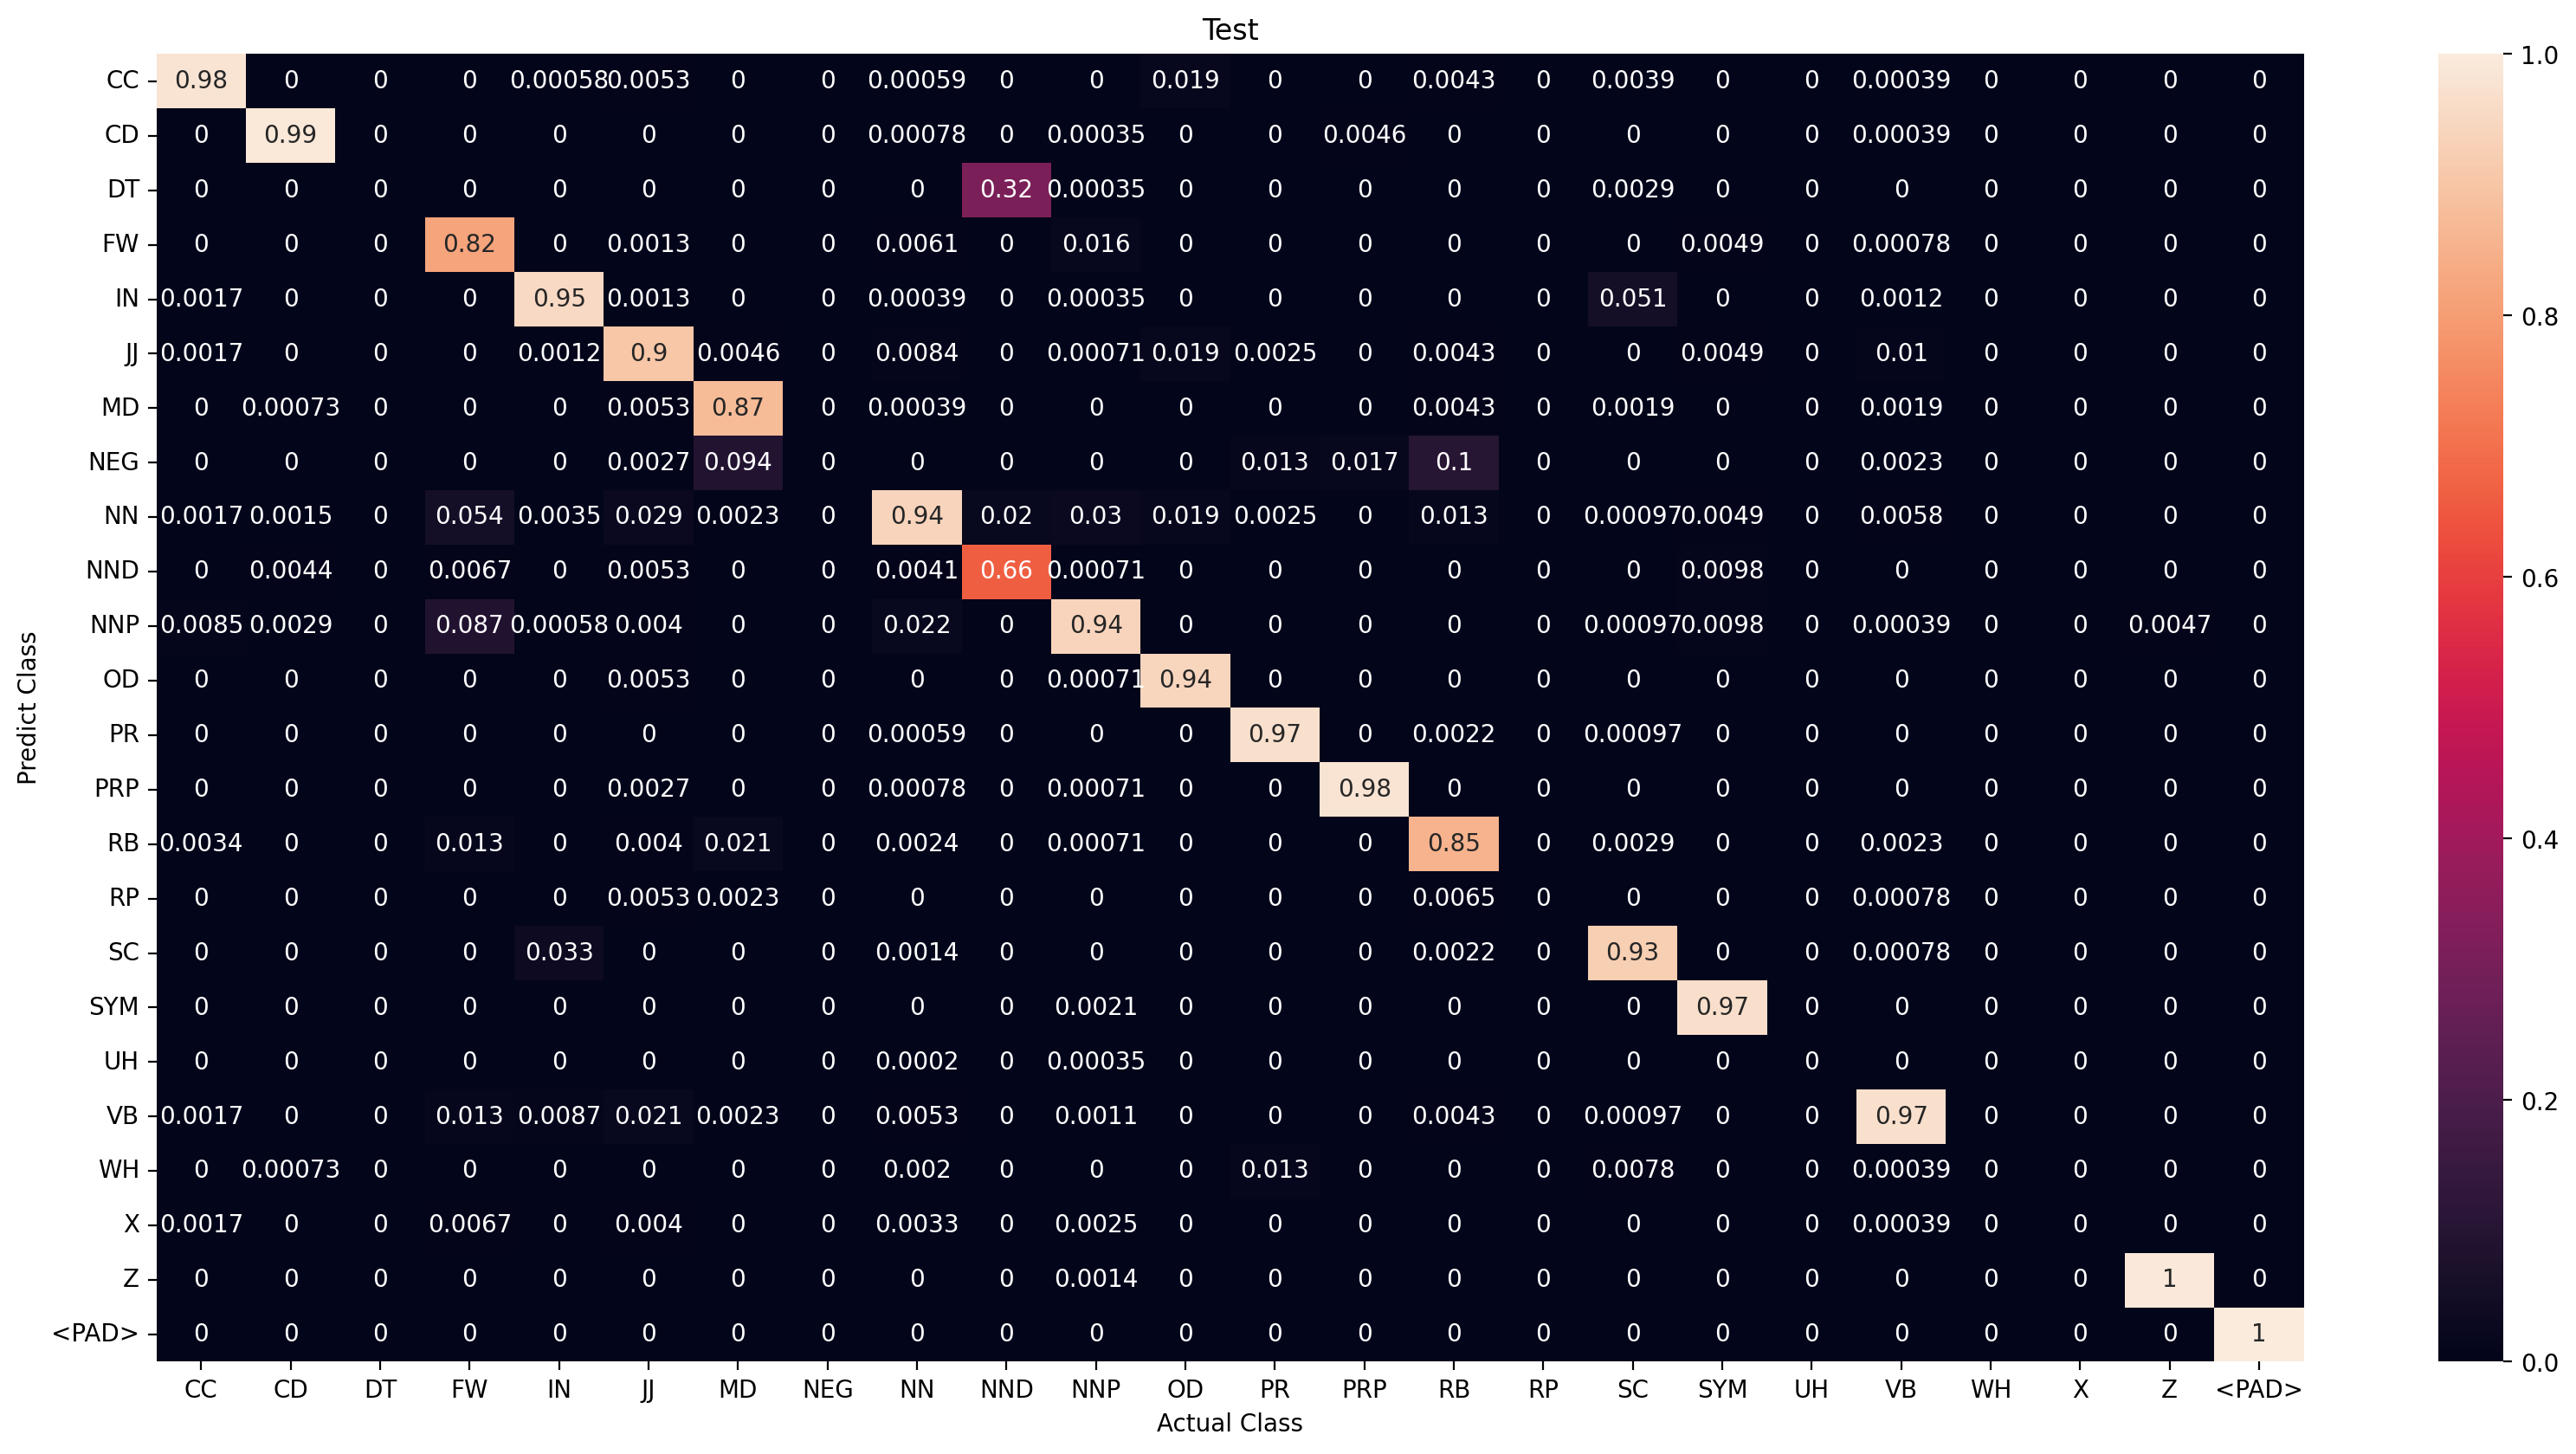

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5276       | CC    : 121      |
| CD    : 12862  | CD    : 12758      | CD    : 104      |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1313       | FW    : 292      |
| IN    : 15290  | IN    : 15146      | IN    : 144      |
| JJ    : 7025   | JJ    : 6711       | JJ    : 314      |
| MD    : 3798   | MD    : 3686       | MD    : 112      |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 44010      | NN    : 462      |
| NND   : 1033   | NND   : 537        | NND   : 496      |
| NNP   : 25007  | NNP   : 24523      | NNP   : 484      |
| OD    : 519    | OD    : 501        | OD    : 18       |
| PR    : 3880   | PR    : 3858       | PR    : 22       |
| PRP   : 5449   | PRP   : 5402       | PRP   : 47       |
| RB    : 3502   | RB    : 3369       | RB    : 133      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11339
Wrong prediction            : 632
Percentage correct oov pred : 94.72057472224543

Validation
Number OOV token            : 3190
Correct prediction          : 2884
Wrong prediction            : 306
Percentage correct oov pred : 90.40752351097179

Test
Number OOV token            : 1401
Correct prediction          : 1275
Wrong prediction            : 126
Percentage correct oov pred : 91.00642398286938



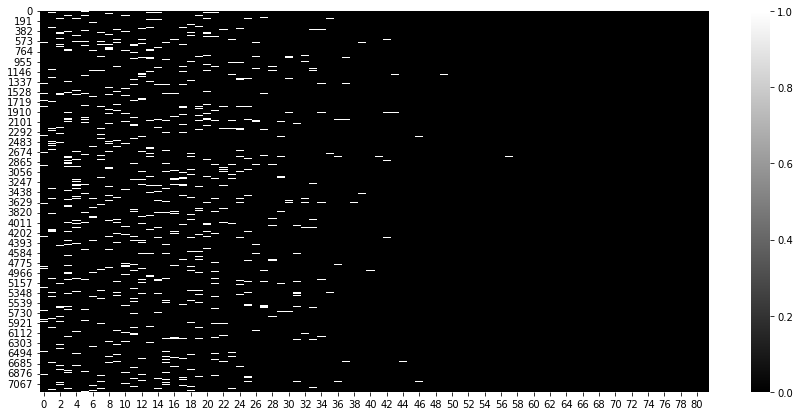

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

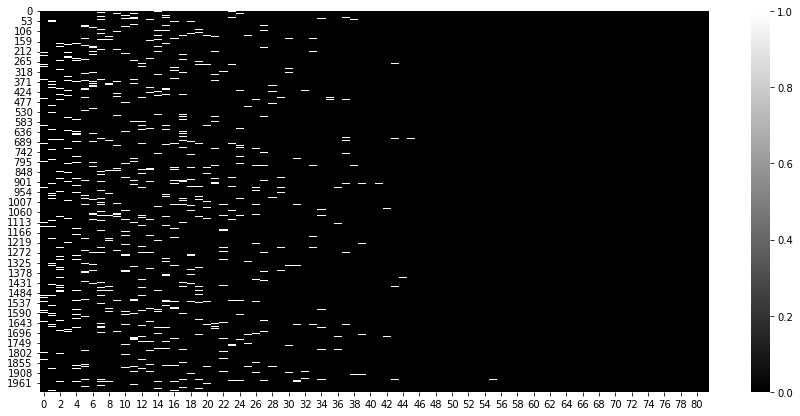

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

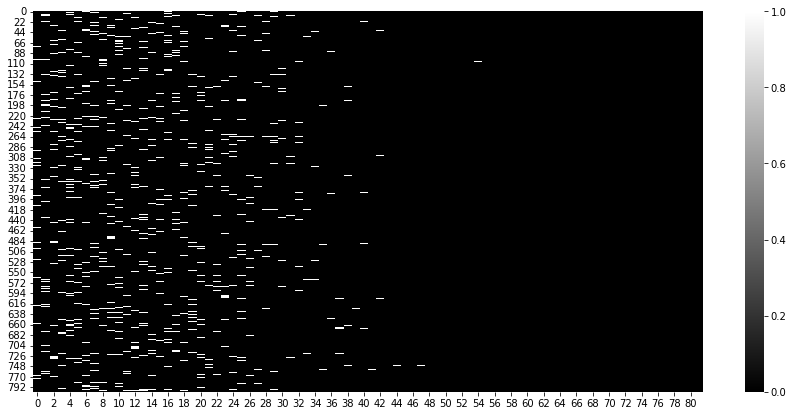

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);